In [25]:
import sys
import os

project_root = os.path.abspath("..")
scripts_path = os.path.join(project_root, "scripts")

# Add the scripts folder to the Python path
sys.path.append(scripts_path)

In [26]:
import torch
import os
import cv2
import numpy as np
from sparsemodel import UNet  # Replace with your model import path
from dataset import add_rectangle, PirateLogDataset
from utils import color2class  # Assuming this is the function for color mapping
import matplotlib.pyplot as plt
from tqdm import tqdm

In [27]:
# CONFIGURATION
MODEL_PATH = "../results/best_model.pth"  # Path to your saved model
TEST_IMG_DIR = "../data/test"  # Directory containing test images
OUTPUT_DIR = "../results/test_predictions"  # Directory to save predictions
TARGET_SIZE = (3200 // 2, 2496 // 2)
N_CLASSES = 6  # Number of segmentation classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [28]:
# Define the class colors for visualization
class_colors = {
    0: (255, 0, 0),  # Example RGB mappings
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 255, 0),
    4: (255, 0, 255),
    5: (0, 255, 255),
}

In [29]:
def preprocess_image(image_path):
    """
    Preprocess a test image using the same logic as in the PirateLogDataset class.
    """
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = add_rectangle(img)
    _, img = cv2.threshold(img, 8, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.erode(img, kernel, iterations=2)

    img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    img_resized = img_resized / 255.0
    # img_resized = img / 255.

    # Convert to PyTorch tensor with channel-first format
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float()

    return img_tensor.unsqueeze(0)  # Add batch dimension

In [30]:
def class_to_color(prediction, class_colors):
    """
    Convert class indices to RGB colors for visualization.
    """
    color_mask = np.zeros((*prediction.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[prediction == class_idx] = color
    return color_mask


In [31]:
# Load the model
model = UNet(N_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

UNet(
  (dropout): Dropout(p=0.5, inplace=False)
  (e11): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(64, eps=1e-05, momentum

In [32]:
test_images = sorted(os.listdir(TEST_IMG_DIR))[:10]  # Load only 10 test images

In [33]:
print(test_images)

['8013620831-0038.jpg-b.jpg', '8013620831-0043.jpg-t.jpg', '8013620831-0045.jpg-b.jpg', '8013620831-0047.jpg-b.jpg', '8013620831-0829.jpg-b.jpg', '8013620831-0832.jpg-b.jpg', '8013620831-0833.jpg-b.jpg']


Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Saved prediction for 8013620831-0038.jpg-b.jpg to ../results/test_predictions\8013620831-0038.jpg-b_prediction.png


Testing:  14%|█▍        | 1/7 [00:22<02:15, 22.63s/it]

Saved prediction for 8013620831-0043.jpg-t.jpg to ../results/test_predictions\8013620831-0043.jpg-t_prediction.png


Testing:  29%|██▊       | 2/7 [00:44<01:51, 22.38s/it]

Saved prediction for 8013620831-0045.jpg-b.jpg to ../results/test_predictions\8013620831-0045.jpg-b_prediction.png


Testing:  29%|██▊       | 2/7 [01:07<02:47, 33.51s/it]


KeyboardInterrupt: 

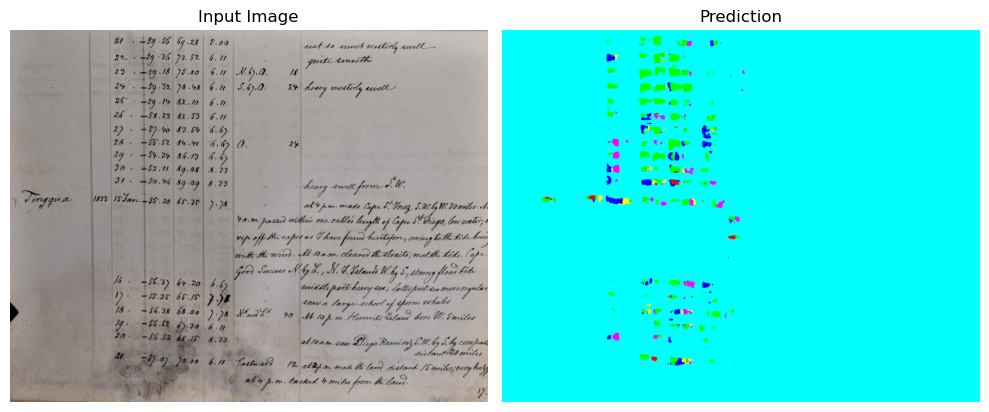

In [34]:
test_images = sorted(os.listdir(TEST_IMG_DIR))[:10]  # Load only 10 test images

# Run inference
for img_name in tqdm(test_images, desc="Testing"):
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    
    # Preprocess the image
    img_tensor = preprocess_image(img_path).to(DEVICE)

    with torch.no_grad():
        # Get model predictions
        output = model(img_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Convert the prediction to color format
    pred_color = class_to_color(prediction, class_colors)

    # Save the prediction
    output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_name)[0]}_prediction.png")
    cv2.imwrite(output_path, pred_color)
    print(f"Saved prediction for {img_name} to {output_path}")

    # Optional: Visualization (input image + prediction)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(pred_color)
    plt.title("Prediction")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_name)[0]}_overlay.png"))
    plt.close()